The idea of this project to build a model which will predict price movements for financial instruments traded on Stock Exchange based on publicly available Limited Order Book for these financial instruments. 

Materials by Authors: Zihao Zhang, Stefan Zohren and Stephen Roberts for DeepLOB: Deep Convolutional Neural Networks for Limit Order Books were used to create this project. 

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
# Let's import necessary libraries
import os
import zipfile
import pandas as pd
import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout,Conv2D,concatenate    
from tensorflow.keras.layers import MaxPooling2D, LSTM, LeakyReLU,Reshape
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping 

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import seaborn as sns

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**We will use the benchmark FI-2010 Dataset downloaded from https://etsin.fairdata.fi/ and Published by Ministry of Education and Culture, Finland.**

**Below is the synopsis for the dataset**

Here we provide the normalized datasets as .txt files. The datasets are divided into two main categories: datasets that include the auction period and datasets that do not. For each of these two categories we provide three normalization set-ups based on z-score, min-max, and decimal-precision normalization. Since we followed the anchored cross-validation method for 10 days for 5 stocks, the user can find nine (cross-fold) datasets for each normalization set-up for training and testing. Every training and testing dataset contains information for all the stocks. For example, the first fold contains one-day of training and one-day of testing for all the five stocks. The second fold contains the training dataset for two days and the testing dataset for one day. The two-days information the training dataset has is the training and testing from the first fold and so on.

The title of the .txt files contains the information in the following order:

training or testing set
with or without auction period
type of the normalization setup
fold number (from 1 to 9) based on the above cross-validation method
ATTENTION: The given files contain both the feature set and the labels. From row 1 to row 144 we provide the features (see 'Benchmark Dataset for Mid-Price Prediction of Limit Order Book Data' for the description) and from row 145 to row 149 we provide labels for 5 classification problems. Labels (row 145 to the end) have the following explanation ‘1’ is for up-movement, ‘2’ is for stationary condition and ‘3’ is for down-movement.

In [ ]:
# Let's read the dataset
zip_file=zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/BenchmarkDatasets.zip')
zip_file.namelist()

['BenchmarkDatasets/',
 'BenchmarkDatasets/Auction/',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_1.txt',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_2.txt',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_3.txt',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_4.txt',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_5.txt',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_6.txt',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_7.txt',
 'BenchmarkDatasets/Auction/1.Auction_Zscore/Auction_Zscore_Testing/Test_Dst_Auction_ZScore_CF_8.txt',
 'B

We use only no-Auction data for our model. 
The data is represented in folds, see the synopsis for the dataset above
We plan to split data as 60% for training, 20% - for validation and 20% for testing. 
So we need to collect all the data in one array by adding 
9th cross-validation fold (CF_9) of testing data to training CF-9
and then split it accordingly.

In [ ]:
# Let's download the 9th fold training array
array_train_CF9=np.loadtxt(zip_file.open(
    'BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_9.txt'))
df_train_CF9=pd.DataFrame(array_train_CF9.T)
df_train_CF9

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,0.318116,-0.564619,0.313539,-0.551889,0.319726,-0.731228,0.312891,-0.425448,0.319404,-0.844157,...,-0.816832,-0.825238,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
1,0.318116,-0.662079,0.313539,-0.551889,0.320706,-0.751891,0.312891,-0.425448,0.320383,-0.854876,...,0.464300,0.452887,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
2,0.317136,-0.723163,0.313539,-0.551889,0.316787,-0.731228,0.312891,-0.425448,0.317445,-0.762942,...,-0.798788,-0.807237,0.0,0.0,0.0,3.0,3.0,2.0,2.0,2.0
3,0.317136,-0.585895,0.313539,-0.551889,0.318747,-0.307628,0.312891,-0.425448,0.319404,-0.561348,...,0.465974,0.454558,0.0,0.0,0.0,2.0,2.0,3.0,2.0,2.0
4,0.317136,-0.585895,0.313539,-0.551889,0.318747,-0.307628,0.312891,-0.425448,0.319404,-0.561348,...,-0.410306,-0.419666,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362395,1.328480,-0.608544,1.329517,-0.550603,1.327892,-0.795514,1.330085,-0.719126,1.328302,-0.870542,...,-0.697642,-0.706328,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
362396,1.328480,-0.608544,1.329517,-0.550603,1.327892,-0.795514,1.330085,-0.611748,1.328302,-0.870542,...,0.460395,0.448992,0.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0
362397,1.328480,-0.608544,1.329517,-0.550603,1.327892,-0.795514,1.330085,-0.611748,1.328302,-0.870542,...,-0.827738,-0.836118,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0
362398,1.328480,-0.668256,1.329517,-0.354503,1.327892,-0.795514,1.330085,-0.611748,1.328302,-0.870542,...,0.590491,0.578783,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0


In [ ]:
dict_test_CF={}
for i in range(1,10):
  array_test_CF=np.loadtxt(zip_file.open(
      'BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_'+str(i)+'.txt'))
  dict_test_CF[i]=array_test_CF

In [ ]:
df_test_CF9=pd.DataFrame(dict_test_CF[9].T)
df_test_CF9

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,0.381815,-0.669628,0.380290,-0.453518,0.383410,-0.454568,0.380638,-0.523162,0.384052,-0.870542,...,2.770823,2.753998,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
1,0.381815,-0.669628,0.382253,-0.567963,0.383410,-0.454568,0.380638,-0.630002,0.384052,-0.870542,...,1.685417,1.671139,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
2,0.381815,-0.669628,0.379308,-0.440016,0.382431,-0.788626,0.375729,-0.254717,0.382093,-0.630608,...,3.039488,3.022033,0.0,0.0,0.0,3.0,3.0,2.0,2.0,2.0
3,0.381815,-0.669628,0.380290,-0.567963,0.382431,-0.788626,0.380638,-0.630002,0.382093,-0.630608,...,3.469352,3.450888,0.0,0.0,0.0,1.0,1.0,3.0,2.0,2.0
4,0.381815,-0.669628,0.378326,-0.549317,0.382431,-0.788626,0.378674,-0.522625,0.382093,-0.630608,...,3.684283,3.665316,0.0,0.0,0.0,3.0,3.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31932,1.462738,-0.030648,1.467926,-0.197623,1.462118,-0.401187,1.465580,-0.569871,1.461516,-0.004800,...,1.624460,1.610326,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
31933,1.462738,-0.030648,1.467926,-0.197623,1.462118,-0.401187,1.465580,-0.623560,1.461516,-0.004800,...,-0.824794,-0.833181,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
31934,1.462738,-0.030648,1.467926,-0.197623,1.462118,-0.401187,1.465580,-0.677249,1.461516,-0.004800,...,-0.494134,-0.503298,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
31935,1.462738,-0.030648,1.467926,-0.197623,1.462118,-0.401187,1.466562,-0.737917,1.461516,-0.004800,...,0.460724,0.449320,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0


In [ ]:
full_data_array=np.hstack((array_train_CF9,dict_test_CF[9]))

In [ ]:
df_full_data=pd.DataFrame(full_data_array.T)
df_full_data

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,0.318116,-0.564619,0.313539,-0.551889,0.319726,-0.731228,0.312891,-0.425448,0.319404,-0.844157,...,-0.816832,-0.825238,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
1,0.318116,-0.662079,0.313539,-0.551889,0.320706,-0.751891,0.312891,-0.425448,0.320383,-0.854876,...,0.464300,0.452887,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
2,0.317136,-0.723163,0.313539,-0.551889,0.316787,-0.731228,0.312891,-0.425448,0.317445,-0.762942,...,-0.798788,-0.807237,0.0,0.0,0.0,3.0,3.0,2.0,2.0,2.0
3,0.317136,-0.585895,0.313539,-0.551889,0.318747,-0.307628,0.312891,-0.425448,0.319404,-0.561348,...,0.465974,0.454558,0.0,0.0,0.0,2.0,2.0,3.0,2.0,2.0
4,0.317136,-0.585895,0.313539,-0.551889,0.318747,-0.307628,0.312891,-0.425448,0.319404,-0.561348,...,-0.410306,-0.419666,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394332,1.462738,-0.030648,1.467926,-0.197623,1.462118,-0.401187,1.465580,-0.569871,1.461516,-0.004800,...,1.624460,1.610326,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
394333,1.462738,-0.030648,1.467926,-0.197623,1.462118,-0.401187,1.465580,-0.623560,1.461516,-0.004800,...,-0.824794,-0.833181,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
394334,1.462738,-0.030648,1.467926,-0.197623,1.462118,-0.401187,1.465580,-0.677249,1.461516,-0.004800,...,-0.494134,-0.503298,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0
394335,1.462738,-0.030648,1.467926,-0.197623,1.462118,-0.401187,1.466562,-0.737917,1.461516,-0.004800,...,0.460724,0.449320,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0


For the features we need only the first 40 
as these features are the first 10 levels of bid and ask price for the limited order book.
We use only 10 levels because the most impact on price discovery is made by 
best bid and best ask orders and then importance's quickly 
plummeting with each level. It leads deep levels not to carry any important information and likely to be deteriorating the model's accuracy. 
The reason behind this is that more than 90% of limited orders are submitted by traders and then withdrawn. 

In [ ]:
# Let's get the features and the labels from the data.   
full_features=full_data_array[:40].T
full_labels=full_data_array[-5:].T

In [ ]:
# Let's create train, validation and test datasets

# features 
train_features=full_features[:int(np.ceil(full_features.shape[0]*0.6)),:]
val_features=full_features[int(np.ceil(full_features.shape[0]*0.6)):int(np.ceil(full_features.shape[0]*0.8)),:]
test_features=full_features[int(np.ceil(full_features.shape[0]*0.8)):,:]

# labels
train_labels=full_labels[:int(np.ceil(full_labels.shape[0]*0.6)),:]
val_labels=full_labels[int(np.ceil(full_labels.shape[0]*0.6)):int(np.ceil(full_labels.shape[0]*0.8)),:]
test_labels=full_labels[int(np.ceil(full_labels.shape[0]*0.8)):,:]

In [ ]:
print(train_features.shape)
print(val_features.shape)
print(test_features.shape)
print('')
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(236603, 40)
(78867, 40)
(78867, 40)

(236603, 5)
(78867, 5)
(78867, 5)


In [ ]:
# Let's prepare data for the model
def data_preparation(features, labels, T, k):
    
  # features
  [n,d]=features.shape
  X= np.zeros((n - T + 1, T, d))
  for i in range(T, n + 1):
      X[i - T] = features[i - T:i, :]
  X=X.reshape(X.shape + (1,))

  # labels
  y = labels[T - 1:n]
  y = y[:,k] - 1
  y = to_categorical(y, 3)
  
  return X,y

In [ ]:
# k corresponds to horizon for predicted classes in FI-2010 
# according to the dataset description rows 145-149 correspond to 
# 1,2, 3, 5 and 10 predicted horizons accordingly
# we choose 10 horizons, which will correspond to the last 5th row (149), so  
k=4
# The size of the single input to the model is 100 consecutive events
T=100

In [ ]:
# Let's get prepared features and labels for each part of the dataset
X_train,y_train=data_preparation(train_features, train_labels, T, k)

In [ ]:
X_val,y_val=data_preparation(val_features, val_labels, T, k)

In [ ]:
X_test,y_test=data_preparation(test_features, test_labels, T, k)

In [ ]:
# Let's check the shape of the final Inputs and Labels
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(236504, 100, 40, 1) (236504, 3)
(78768, 100, 40, 1) (78768, 3)
(78768, 100, 40, 1) (78768, 3)


In [ ]:
# Let's create the model
def build_deepLOB():
  inputs = Input(shape=(100, 40, 1))

  # CNN Blocks

  # Block 1
  cnn = Conv2D(16, (1, 2), strides=(1, 2))(inputs)
  cnn = LeakyReLU(alpha=0.01)(cnn)
  cnn = Conv2D(16, (4, 1),padding='same')(cnn)
  cnn = LeakyReLU(alpha=0.01)(cnn)
  cnn = Conv2D(16, (4, 1),padding='same')(cnn)
  cnn = LeakyReLU(alpha=0.01)(cnn)

  # Block 2
  cnn = Conv2D(16, (1, 2), strides=(1, 2))(cnn)
  cnn = LeakyReLU(alpha=0.01)(cnn)
  cnn = Conv2D(16, (4, 1),padding='same')(cnn)
  cnn = LeakyReLU(alpha=0.01)(cnn)
  cnn = Conv2D(16, (4, 1),padding='same')(cnn)
  cnn = LeakyReLU(alpha=0.01)(cnn)

  # Block 3
  cnn = Conv2D(16, (1, 10))(cnn)
  cnn = LeakyReLU(alpha=0.01)(cnn)
  cnn = Conv2D(16, (4, 1),padding='same')(cnn)
  cnn = LeakyReLU(alpha=0.01)(cnn)
  cnn = Conv2D(16, (4, 1),padding='same')(cnn)
  cnn = LeakyReLU(alpha=0.01)(cnn)

  # Inception blocks 

  # Block 1
  inception1 = Conv2D(32, (1, 1))(cnn)
  inception1 = LeakyReLU(alpha=0.01)(inception1)
  inception1 = Conv2D(32, (3, 1),padding='same')(inception1)
  inception1 = LeakyReLU(alpha=0.01)(inception1)

  # Block 2
  inception2 = Conv2D(32, (1, 1))(cnn)
  inception2 = LeakyReLU(alpha=0.01)(inception2)
  inception2 = Conv2D(32, (5, 1),padding='same')(inception2)
  inception2 = LeakyReLU(alpha=0.01)(inception2)

  # Block 3
  inception3 = MaxPooling2D((3, 1), strides=(1, 1) ,padding='same')(cnn)
  inception3 = Conv2D(32, (1, 1))(inception3)
  inception3 = LeakyReLU(alpha=0.01)(inception3)

  inception_output = concatenate([inception1, inception2, inception3], axis=-1)
  inception_output = Reshape((int(inception_output.shape[1]), int(inception_output.shape[3])))(inception_output)
  inception_output = Dropout(0.2, noise_shape=(None, 1, int(inception_output.shape[2])))(inception_output, training=True)

  # LSTM block 
  lstm = LSTM(64)(inception_output)

  # Output Block
  output = Dense(3, activation='softmax')(lstm)
  deepLOB = Model(inputs=inputs, outputs=output)

  deepLOB.compile(optimizer=Adam(epsilon=1, learning_rate=0.01), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return deepLOB

In [ ]:
deepLOB=build_deepLOB()
deepLOB.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 20, 16)  48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 20, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 20, 16)  1040        ['leaky_re_lu[0][0]']        

In [ ]:
epochs = 150

checkpoint = ModelCheckpoint("deepLOB.tf", monitor = 'val_accuracy',
                            save_weights_only = True, mode = 'max', verbose = 1)

#reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 3,min_delta=0.005, min_lr = 0.0001 , mode = 'max')

csv_logger=CSVLogger('/content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_training.csv',append=False)

early_stopping=EarlyStopping(monitor='val_accuracy',min_delta=0.003, patience=20,verbose=1,restore_best_weights=True)

callbacks = [checkpoint,csv_logger,early_stopping]

In [ ]:
deepLOB.fit(X_train, y_train, validation_data=(X_val,y_val),
            epochs=epochs, batch_size=32, verbose=1,callbacks=callbacks)

Epoch 1/150
7391/7391 [==============================] - ETA: 0s - loss: 1.0593 - accuracy: 0.4029
Epoch 1: saving model to deepLOB.tf
7391/7391 [==============================] - 114s 14ms/step - loss: 1.0593 - accuracy: 0.4029 - val_loss: 1.1171 - val_accuracy: 0.3603
Epoch 2/150
7391/7391 [==============================] - ETA: 0s - loss: 0.8833 - accuracy: 0.4976
Epoch 2: saving model to deepLOB.tf
7391/7391 [==============================] - 101s 14ms/step - loss: 0.8833 - accuracy: 0.4976 - val_loss: 1.0568 - val_accuracy: 0.3983
Epoch 3/150
7388/7391 [============================>.] - ETA: 0s - loss: 0.8125 - accuracy: 0.5312
Epoch 3: saving model to deepLOB.tf
7391/7391 [==============================] - 102s 14ms/step - loss: 0.8125 - accuracy: 0.5312 - val_loss: 0.8882 - val_accuracy: 0.5108
Epoch 4/150
7389/7391 [============================>.] - ETA: 0s - loss: 0.7961 - accuracy: 0.5456
Epoch 4: saving model to deepLOB.tf
7391/7391 [==============================] - 103s 14

In [ ]:
# Let's create new model and run training once again
epochs = 150

ckpt_path='/content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_1/deepLOB_1.tf'
checkpoint = ModelCheckpoint(ckpt_path, monitor = 'val_accuracy',
                            save_weights_only = True, mode = 'max', verbose = 1)

#reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 3,min_delta=0.005, min_lr = 0.0001 , mode = 'max')

csv_logger_path= '/content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_1_training.csv'
csv_logger=CSVLogger(csv_logger_path,append=False)

early_stopping=EarlyStopping(monitor='val_accuracy',min_delta=0.003, patience=20,verbose=1,restore_best_weights=True)

callbacks = [checkpoint,csv_logger,early_stopping]

In [ ]:
deepLOB_1=build_deepLOB()
deepLOB_1.fit(X_train, y_train, validation_data=(X_val,y_val),
            epochs=epochs, batch_size=32, verbose=1,callbacks=callbacks)

Epoch 1/150
7391/7391 [==============================] - ETA: 0s - loss: 1.0043 - accuracy: 0.4277
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_1/deepLOB_1.tf
7391/7391 [==============================] - 120s 14ms/step - loss: 1.0043 - accuracy: 0.4277 - val_loss: 1.1048 - val_accuracy: 0.3699
Epoch 2/150
7391/7391 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.5199
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_1/deepLOB_1.tf
7391/7391 [==============================] - 101s 14ms/step - loss: 0.8358 - accuracy: 0.5199 - val_loss: 0.9215 - val_accuracy: 0.4956
Epoch 3/150
7387/7391 [============================>.] - ETA: 0s - loss: 0.8057 - accuracy: 0.5345
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_1/deepLOB_1.tf
7391/7391 [===========================

In [ ]:
# Let's create new model and run training once again
epochs = 150

ckpt_path='/content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_2/deepLOB_2.tf'
checkpoint = ModelCheckpoint(ckpt_path, monitor = 'val_accuracy',
                            save_weights_only = True, mode = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 3,min_delta=0.005, min_lr = 0.0001 , mode = 'max')

csv_logger_path= '/content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_2_training.csv'
csv_logger=CSVLogger(csv_logger_path,append=False)

early_stopping=EarlyStopping(monitor='val_accuracy',min_delta=0.003, patience=20,verbose=1,restore_best_weights=True)

callbacks = [checkpoint,reduce_lr,csv_logger,early_stopping]

In [ ]:
deepLOB_2=build_deepLOB()
deepLOB_2.fit(X_train, y_train, validation_data=(X_val,y_val),
            epochs=epochs, batch_size=32, verbose=1,callbacks=callbacks)

Epoch 1/150
7390/7391 [============================>.] - ETA: 0s - loss: 1.0436 - accuracy: 0.4114
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_2/deepLOB_2.tf
7391/7391 [==============================] - 113s 14ms/step - loss: 1.0436 - accuracy: 0.4114 - val_loss: 1.1920 - val_accuracy: 0.3605 - lr: 0.0100
Epoch 2/150
7389/7391 [============================>.] - ETA: 0s - loss: 0.8766 - accuracy: 0.5019
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_2/deepLOB_2.tf
7391/7391 [==============================] - 104s 14ms/step - loss: 0.8766 - accuracy: 0.5019 - val_loss: 0.9468 - val_accuracy: 0.4903 - lr: 0.0100
Epoch 3/150
7390/7391 [============================>.] - ETA: 0s - loss: 0.8203 - accuracy: 0.5313
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_2/deepLOB_2.tf
7391/7391 [=

In [ ]:
# Let's create new model and run training once again
epochs = 150

ckpt_path='/content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_3/deepLOB_3.tf'
checkpoint = ModelCheckpoint(ckpt_path, monitor = 'val_accuracy',
                            save_weights_only = True, mode = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5, min_lr = 0.0001 , mode = 'max')

csv_logger_path= '/content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_3_training.csv'
csv_logger=CSVLogger(csv_logger_path,append=False)

early_stopping=EarlyStopping(monitor='val_accuracy', patience=20,verbose=1,restore_best_weights=True)

callbacks = [checkpoint,reduce_lr,csv_logger,early_stopping]

In [ ]:
deepLOB_3=build_deepLOB()
deepLOB_3.fit(X_train, y_train, validation_data=(X_val,y_val),
            epochs=epochs, batch_size=32, verbose=1,callbacks=callbacks)

Epoch 1/150
7391/7391 [==============================] - ETA: 0s - loss: 0.9855 - accuracy: 0.4382
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_2/deepLOB_3.tf
7391/7391 [==============================] - 125s 16ms/step - loss: 0.9855 - accuracy: 0.4382 - val_loss: 1.1063 - val_accuracy: 0.3671 - lr: 0.0100
Epoch 2/150
7389/7391 [============================>.] - ETA: 0s - loss: 0.8208 - accuracy: 0.5269
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_2/deepLOB_3.tf
7391/7391 [==============================] - 107s 14ms/step - loss: 0.8208 - accuracy: 0.5268 - val_loss: 0.9143 - val_accuracy: 0.5099 - lr: 0.0100
Epoch 3/150
7388/7391 [============================>.] - ETA: 0s - loss: 0.7994 - accuracy: 0.5369
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_2/deepLOB_3.tf
7391/7391 [=

In [ ]:
# Let's load the best weights for the model (deepLOB_2) 
deepLOB_2=build_deepLOB()
deepLOB_2.load_weights('/content/drive/MyDrive/Colab Notebooks/Limited order book Forecasting/Saved Models/deepLOB_2/deepLOB_2.tf')

In [ ]:
pred=deepLOB_2.predict(X_test)

2462/2462 [==============================] - 15s 6ms/step


In [ ]:
# Let's print accuracy-score
print('accuracy_score:', round(accuracy_score(np.argmax(y_test, axis=1), np.argmax(pred, axis=1)),3))

accuracy_score: 0.718


               precision    recall  f1-score   support

  up-movement       0.70      0.73      0.71     27313
   stationary       0.82      0.71      0.76     27386
down-movement       0.65      0.72      0.68     24069

     accuracy                           0.72     78768
    macro avg       0.72      0.72      0.72     78768
 weighted avg       0.72      0.72      0.72     78768



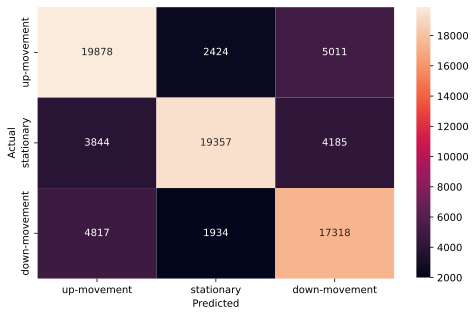

In [ ]:
# Printing the classification report
print(classification_report(np.argmax(y_test,axis=1), np.argmax(pred,axis=1),
                            target_names=['up-movement', 'stationary', 'down-movement']))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(pred,axis=1))
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f',
            xticklabels = ['up-movement', 'stationary', 'down-movement'], 
            yticklabels = ['up-movement', 'stationary', 'down-movement'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()